In [1]:
# Importing the libraries
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import imagehash
from tqdm.notebook import tqdm
import tensorflow as tf

In [2]:
# Loading the tabular dataset containing metadata of the pet images
df_meta = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
df_meta.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [3]:
# Checking the size of the dataset
df_meta.shape

(9912, 14)

<AxesSubplot:>

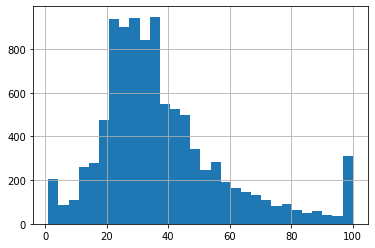

In [4]:
df_meta["Pawpularity"].hist(bins=30)

In [5]:
# Creating a function to calculate hash value of all images
def calculate_hash():
    hash_func = [
        imagehash.average_hash,
        imagehash.phash,
        imagehash.dhash,
        imagehash.whash
    ]
    
    pet_ids = []
    hash_values = []
    
    for i in tqdm(glob.glob("../input/petfinder-pawpularity-score/train/*.jpg")):
        image = Image.open(i)
        image_id = i.split("/")[-1].split(".")[0]
        pet_ids.append(image_id)
        hash_values.append(np.array([h(image).hash for h in hash_func]).flatten())
        
    return pet_ids, np.array(hash_values)

pet_ids, hash_values = calculate_hash()

  0%|          | 0/9912 [00:00<?, ?it/s]

In [18]:
hash_values.shape

(9912, 256)

In [ ]:
# Converting the numpy array to tensors for faster computation
hash_values_t = tf.constant(hash_values.astype(int))

In [7]:
# Calculating the similarity scores of all images to all other images and normalizing it to 0-1
similarity_scores = np.array([(hash_values_t[i] == hash_values_t).numpy().sum(axis=1)/255 
                                  for i in range(hash_values_t.shape[0])])

In [8]:
similarity_scores.shape

(9912, 9912)

In [60]:
# Create a function to display similar images along with paw_score when threshold, max_display is given
def show_duplicates(low_thr=0.0, high_thr=1.0, max_display=None):
    indices_x = np.where(similarity_scores > 0.9)
    indices_y = np.where(indices_x[0] != indices_x[1])
    duplicates = {tuple(sorted([pet_ids[index_1], pet_ids[index_2]])) : similarity_scores[index_1, index_2] 
                       for index_1, index_2 in zip(indices_x[0][indices_y], indices_x[1][indices_y])}
    print(f"Total dupicate pairs: {len(duplicates)}")
    
    count = 1
    for (id_1, id_2), similarity_score in duplicates.items():
        path_1 = f"../input/petfinder-pawpularity-score/train/{id_1}.jpg"
        path_2 = f"../input/petfinder-pawpularity-score/train/{id_2}.jpg"
        paw_sc_1 = df_meta[df_meta["Id"] == id_1]["Pawpularity"].iloc[-1]
        paw_sc_2 = df_meta[df_meta["Id"] == id_2]["Pawpularity"].iloc[-1]

        image_1 = cv2.cvtColor(cv2.imread(path_1), cv2.COLOR_BGR2RGB)
        image_2 = cv2.cvtColor(cv2.imread(path_2), cv2.COLOR_BGR2RGB)

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        axes[0].set_title(f"Pawpularity Score: {paw_sc_1} \n Id: {id_1}")
        axes[0].imshow(image_1)
        axes[1].set_title(f"Pawpularity Score: {paw_sc_2} \n Id: {id_2}")
        axes[1].imshow(image_2)
        fig.suptitle(f"Similarity Score: {similarity_score}")
        plt.show()

        if count >= max_display:
            break
        
        count+=1
    return duplicates

Total dupicate pairs: 27


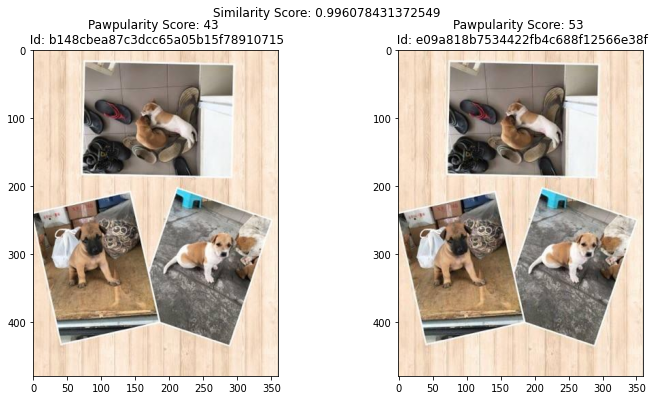

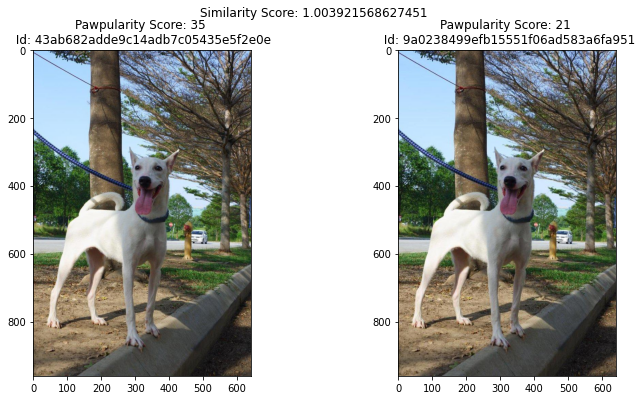

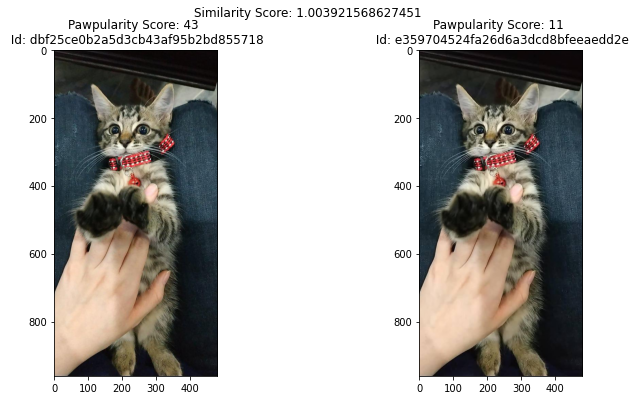

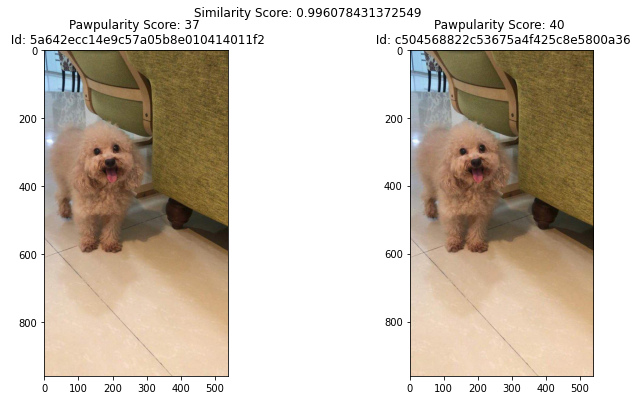

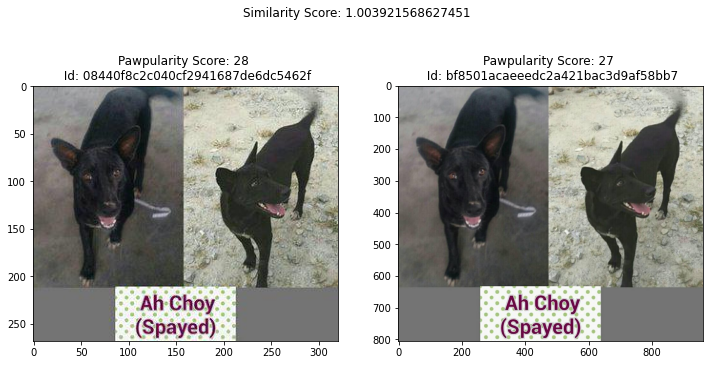

In [62]:
# Displaying duplicate images along with their pawpularity score
dups_90andabove = show_duplicates(0.9, 1.0, max_display = 5)

In [83]:
# Creating a new directory for clean data
!mkdir ./petfinder-pawpularity-score-cleaned
!cp -r ../input/petfinder-pawpularity-score/* ./petfinder-pawpularity-score-cleaned

In [84]:
# Creating a clean dataset by removing all the duplicates having similarity score > 90
id_1 = np.array(list(dups_90andabove.keys()))[:, 0]
id_2 = np.array(list(dups_90andabove.keys()))[:, 1]

train_cleaned = df_meta[~df_meta["Id"].isin(id_2)]
train_cleaned = train_cleaned.reset_index(drop = True)

train_cleaned.to_csv("./petfinder-pawpularity-score-cleaned/train.csv", index = False)
train_cleaned.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [86]:
# Removing all duplicate images now with the help of Ids
for id_ in id_2:
    dup_path = f"../input/petfinder-pawpularity-score-cleaned/train/{id_2}.jpg"
    if os.path.exists("../input/petfinder-pawpularity-score-cleaned/train/{id_2}.jpg"):
        os.remove(dup_path)